# Part 4: Depth from Video -- Basic

1. Write a program to estimate depth map from video using the method described in this paper

In [1]:
import gco.pygco as pygco
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
# Load camera matrices
num_frame = int(np.loadtxt('Road/cameras.txt',dtype=np.float32, max_rows=1))
cam = np.loadtxt('Road/cameras.txt',dtype=np.float32, skiprows=1)
K = []
R = []
T = []
for i in range(num_frame):
    K.append(cam[7*i : 7*i + 3, :])
    R.append(cam[7*i + 3 : 7*i +6, :])
    T.append(cam[7*i + 6, :])
K = np.array(K)
R = np.array(R)
T = np.array(T)


In [3]:
# Load images
image_folder = 'Road/src'

images = []

for item in os.listdir(image_folder):
    image_path = os.path.join(image_folder, item)
    image = cv2.imread(image_path)
    print(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

images = np.array(images)

[[[255 255 247]
  [255 255 247]
  [255 255 247]
  ...
  [255 248 215]
  [255 248 215]
  [255 248 215]]

 [[255 255 247]
  [255 255 247]
  [255 255 247]
  ...
  [255 248 215]
  [255 248 215]
  [255 248 215]]

 [[255 255 247]
  [255 255 247]
  [255 255 247]
  ...
  [255 248 215]
  [255 248 215]
  [255 248 215]]

 ...

 [[118 120 121]
  [119 121 122]
  [121 123 124]
  ...
  [166 172 171]
  [167 172 171]
  [167 172 171]]

 [[104 106 107]
  [105 107 108]
  [107 109 110]
  ...
  [144 149 147]
  [144 149 147]
  [144 149 147]]

 [[ 60  62  63]
  [ 60  62  63]
  [ 60  62  63]
  ...
  [ 77  82  80]
  [ 77  82  80]
  [ 77  82  80]]]
[[[255 255 247]
  [255 255 247]
  [255 255 247]
  ...
  [254 248 219]
  [255 247 217]
  [254 246 216]]

 [[255 255 247]
  [255 255 247]
  [255 255 247]
  ...
  [254 248 219]
  [255 247 217]
  [254 246 216]]

 [[255 255 247]
  [255 255 247]
  [255 255 247]
  ...
  [254 248 219]
  [255 247 217]
  [254 246 216]]

 ...

 [[121 123 124]
  [121 123 124]
  [121 123 124]
  ..

## Disparity initialization

In [4]:
# some basic functions
def color_L2_norm(p1, p2):
    return np.linalg.norm(p1-p2)
    #return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2 )

def compute_xInfinity(x, K1, R1, K2, R2):
        x_infinity = K2 @ R2.T @ R1 @ np.linalg.inv(K1) @ x
        return x_infinity

def compute_ePrime(T1, T2, K2, R2):
        e_prime = K2 @ R2.T @ (T1.T - T2.T)
        return e_prime

In [16]:
import time
from tqdm.notebook import tqdm

class DInit():
    def __init__(self, frames, K, R, T):
        self.N = frames.shape[0] # number of frames
        self.frames = frames
        self.H, self.W = frames[0].shape[:2]
        
        # the camera matrix of the seleted frames
        self.K = K
        self.R = R
        self.T = T

        # some hyper-parameters
        self.number_D = None          # the number of disparity candidates
        self.sigma_c = None                   # the shape of the differentiable robust function in the fd equation
        self.disparity_candidates = None    # the dmin ~ dmax candidates
        self.Ws = None                      # the smoothness strength in the fp equation
        self.Epsilon = None                 # the contrast sensitivity in the fp equation
        self.Eta = None                     # the upper limit of the cost in the fp equation

    def depth_maps(self):   
        depth_maps_init = np.zeros((self.N, self.H, self.W))
        for t in range(self.N):
            data_term = self.compute_fd(t)
            fp, edges, edge_weights = self.compute_prior(t)
            depth_map = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp, algorithm='swap').reshape(self.H, self.W)
            depth_maps_init[t] = depth_map
        return depth_maps_init
    

    def set_parameters(self,sigma_c, Ws, disparity_candidates, Eta, Epsilon):
        self.sigma_c = sigma_c
        self.Ws = Ws
        self.disparity_candidates = disparity_candidates
        self.number_D = len(disparity_candidates)
        self.Eta = Eta
        self.Epsilon = Epsilon


    def one_map(self, t): #t: the selected frame 
        disparity_map_init = np.zeros((self.H, self.W))
        data_term = self.compute_fd(t, save=True)
        fp, edges, edge_weights = self.compute_prior(t)
        disparity_map_init = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp, algorithm='swap').reshape(self.H, self.W)
        return disparity_map_init


    def compute_fd(self, t, save = False):

        It = self.frames[t]
        fd = np.zeros((self.H, self.W, self.number_D))
        K1 = self.K[t]
        R1 = self.R[t]
        T1 = self.T[t]
        other_frames_idx = [a for a in range(self.N) if a != t]

        for t_prime in other_frames_idx:
            It_prime = self.frames[t_prime]
            K2 = self.K[t_prime]
            R2 = self.R[t_prime]
            T2 = self.T[t_prime]

            start = time.time()
            rho_c = self.compute_rho_c(frame1 = It, frame2 = It_prime, K1=K1, R1=R1, T1=T1, K2=K2, R2=R2, T2=T2)
            end = time.time()
            print(f"finished compare {t_prime} in {end-start}")
            fd += rho_c
        Ux =1/ np.max(fd)
        data_term = 1 - Ux * fd
        data_term = data_term.reshape(data_term.shape[0] * data_term.shape[1], data_term.shape[2])
        if save:
            np.save(f'data_terms/part4_Dinit_frame_{t}.npy', data_term)
            print(f'part4_Dinit_frame_{t}.npy saved')
        return data_term



    def compute_prior(self, t):
    
        It = self.frames[t]
        fp = np.zeros((self.number_D, self.number_D))  # pairwise
        for i in range(self.number_D):
            for j in range(self.number_D):
                fp[i][j] = min(abs(self.disparity_candidates[i] - self.disparity_candidates[j]), self.Eta)
        
        edges = []
        edge_weights = []
    
        for y in range(self.H):
            for x in range(self.W):
                color_differences = []
                node1 = y * self.W + x
                Nx = 0                  #number of neighbors
                Ux_down = 0
                if x-1>0:  # the up neighbor
                    Nx +=1
                    color_difference = color_L2_norm(It[y][x], It[y][x-1])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = y * self.W + x-1
                    edges.append([node1, node2])
                if x+1 < self.W:
                    Nx += 1
                    color_difference = color_L2_norm(It[y][x], It[y][x+1])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = y * self.W + x + 1
                    edges.append([node1, node2])
                if y-1>0:
                    Nx +=1
                    color_difference = color_L2_norm(It[y][x], It[y-1][x])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = (y-1) * self.W + x
                    edges.append([node1, node2])
                if y+1 < self.H:
                    Nx += 1
                    color_difference = color_L2_norm(It[y][x], It[y+1][x])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = (y+1) * self.W + x
                    edges.append([node1, node2])

                for neighbor in range(Nx):
                    weight = Nx / ((color_differences[neighbor] + self.Epsilon) * Ux_down)
                    edge_weights.append(weight)
        return self.Ws * fp, np.array(edges), np.array(edge_weights)


    def compute_rho_c(self, frame1, frame2, K1, R1, T1, K2, R2, T2):
        rho_c = np.zeros((self.H, self.W, self.number_D))
        e_prime = compute_ePrime(T1, T2, K2, R2)

        expression = K2 @ R2.T @ R1 @ np.linalg.inv(K1)
        #for y in range(self.H):
        for y in tqdm(range(self.H), desc='Processing Y from 0 to 540', leave=True):
            for x in range(self.W):
                x_h = np.array([x, y, 1])
                for d in range(self.number_D):
                    #x_infinity = compute_xInfinity(x_h, K1=K1, R1=R1, K2=K2, R2=R2).reshape(3, 1)
                    #e_prime=e_prime.reshape(3,1)
                    #x_h_prime = x_infinity + self.disparity_candidates[d]*e_prime
                    x_h_prime = expression @ x_h + self.disparity_candidates[d]*e_prime
                    x_h_prime = x_h_prime * (1.0 / x_h_prime[2]) # normalize

                    # Whether the x_h_prime in the frame t_prime
                    x_h_prime[0] = min(max(0, x_h_prime[0]), self.W-1)
                    x_h_prime[1] = min(max(x_h_prime[1], 0), self.H-1)

                    x_h_prime = x_h_prime.astype(int)
                    p1 = frame1[y, x]
                    p2 = frame2[x_h_prime[1], x_h_prime[0]]
                    #print(p1)
                    #print(p2)
                    # compute rho_c for that pixel
                    rho_c[y][x][d] = self.sigma_c / (self.sigma_c + color_L2_norm(p1, p2))

        return rho_c

In [12]:
# some parameters
N = 5 # the number of frames
sigma_c = 10 # 
number_D = 50 # the number of disparity candidate of each frame
disparity_candidates = np.linspace(0, 0.05, number_D +1)
disparity_candidates = disparity_candidates[1:]
Epsilon = 50
Ws = 500
Eta = 0.5
frames = images[0:N]
K_frames= K[0:N]
R_frames = R[0:N]
T_frames = T[0:N]
H, W = images[0].shape[:2] # the height and width, because all images have same size, so only need compute once

In [7]:
disparity_candidates

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 ])

In [37]:
initMaps = DInit(frames=frames,K=K_frames,R=R_frames,T=T_frames)
initMaps.set_parameters(sigma_c=sigma_c, Ws=Ws, disparity_candidates=disparity_candidates, Eta=Eta, Epsilon=Epsilon)
map_1 = initMaps.one_map(1)

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 0 in 192.51796102523804


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 2 in 192.56723427772522


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 3 in 192.1677851676941


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 4 in 194.42964243888855
part4_Dinit_frame_1.npy saved


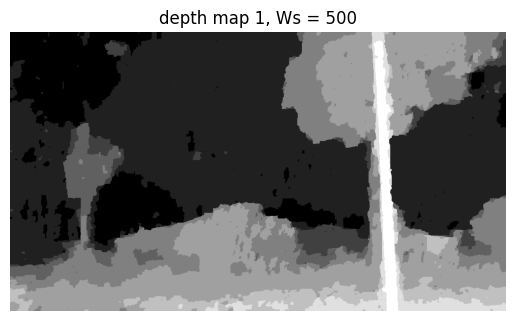

In [38]:
plt.imshow(map_1, cmap='gray')
plt.title(f'depth map 1, Ws = {initMaps.Ws}')
plt.axis('off')
plt.show()

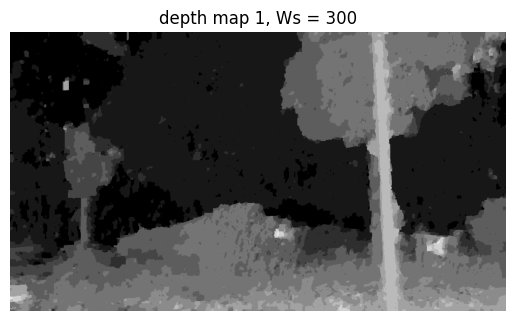

In [39]:
data_term = np.load('data_terms/part4_Dinit_frame_1.npy')
initMaps.Ws = 300
fp, edges, edge_weights = initMaps.compute_prior(1)
disparity_map_init = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp,algorithm='swap').reshape(H, W)
plt.imshow(disparity_map_init, cmap='gray')
plt.title(f'depth map 1, Ws = {initMaps.Ws}')
plt.axis('off')
plt.show()

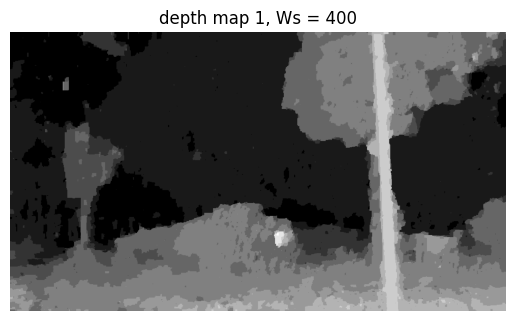

In [40]:
data_term = np.load('data_terms/part4_Dinit_frame_1.npy')
initMaps.Ws = 400
fp, edges, edge_weights = initMaps.compute_prior(1)
disparity_map_init = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp,algorithm='swap').reshape(H, W)
plt.imshow(disparity_map_init, cmap='gray')
plt.title(f'depth map 1, Ws = {initMaps.Ws}')
plt.axis('off')
plt.show()

In [41]:
initMaps.Ws = 500
map_2 = initMaps.one_map(2)

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 0 in 198.49930691719055


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 1 in 203.40361547470093


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 3 in 199.30459022521973


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 4 in 195.92303037643433
part4_Dinit_frame_2.npy saved


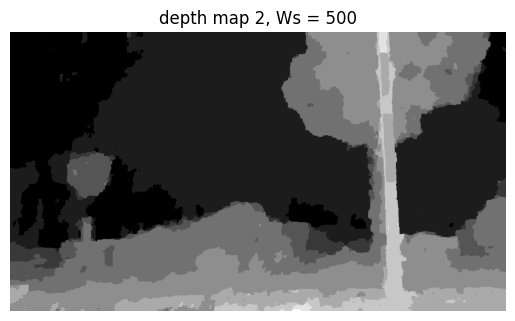

In [42]:
plt.imshow(map_2, cmap='gray')
plt.title(f'depth map 2, Ws = {initMaps.Ws}')
plt.axis('off')
plt.show()

In [ ]:
map_3 = initMaps.one_map(3)
map_4 = initMaps.one_map(4)

In [44]:
map_0 = initMaps.one_map(0)

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 1 in 217.36031222343445


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 2 in 262.4726665019989


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 3 in 194.26958227157593


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

finished compare 4 in 202.5327172279358
part4_Dinit_frame_0.npy saved


In [45]:
dinit_maps = np.array([map_0, map_1, map_2, map_3, map_4])

In [60]:
np.save('data_terms/part4_Dinit_maps.npy', dinit_maps)

For disparity initialization, after set parameters, if want to generate all depth maps, just `dinit_maps = initMaps.depth_maps()`.    
Because I want to change parameters and observe the output, so I generate them one by one.

## Bundle Optimization

In [14]:
class Doptim():
    def __init__(self, frames, K, R, T, dinit_maps):
        self.N = frames.shape[0] # number of frames
        self.frames = frames
        self.H, self.W = frames[0].shape[:2]
        self.dinit_maps = dinit_maps

        # the camera matrix of the seleted frames
        self.K = K
        self.R = R
        self.T = T

        # some hyper-parameters
        self.number_D = None          # the number of disparity candidates
        self.sigma_c = None                   # the shape of the differentiable robust function in the fd equation
        self.disparity_candidates = None    # the dmin ~ dmax candidates
        self.Ws = None                      # the smoothness strength in the fp equation
        self.Epsilon = None                 # the contrast sensitivity in the fp equation
        self.Eta = None                     # the upper limit of the cost in the fp equation
        self.sigma_d = None

    def depth_maps(self):   
        depth_maps_init = np.zeros((self.N, self.H, self.W))
        for t in range(self.N):
            data_term = self.compute_fd(t)
            fp, edges, edge_weights = self.compute_prior(self,t)
            depth_map = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp, algorithm='swap').reshape(self.H, self.W)
            depth_maps_init[t] = depth_map
        return depth_maps_init
    

    def set_parameters(self,sigma_c, Ws, disparity_candidates, Eta, Epsilon, sigma_d):
        self.sigma_c = sigma_c
        self.Ws = Ws
        self.disparity_candidates = disparity_candidates
        self.number_D = len(disparity_candidates)
        self.Eta = Eta
        self.Epsilon = Epsilon
        self.sigma_d = sigma_d


    def one_map(self, t): #t: the selected frame  只跑一张图
        disparity_map_init = np.zeros((self.H, self.W))
        data_term = self.compute_fd(t, save=True)
        fp, edges, edge_weights = self.compute_prior(t)
        disparity_map_init = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp, algorithm='swap').reshape(self.H, self.W)
        return disparity_map_init


    def compute_fd(self, t, save):
        #It = self.frames[t]
        fd = np.zeros((self.H, self.W, self.number_D))
        K1 = self.K[t]
        R1 = self.R[t]
        T1 = self.T[t]
        other_frames_idx = [a for a in range(self.N) if a != t]

        for t_prime in other_frames_idx:
            #It_prime = self.frames[t_prime]
            K2 = self.K[t_prime]
            R2 = self.R[t_prime]
            T2 = self.T[t_prime]

            likelihood = self.compute_likelihood(t, t_prime, K1=K1, R1=R1, T1=T1, K2=K2, R2=R2, T2=T2)

            fd += likelihood
        Ux = 1/np.max(fd)
        data_term = 1 - Ux * fd
        data_term = data_term.reshape(data_term.shape[0] * data_term.shape[1], data_term.shape[2])
        if save:
            np.save(f'data_terms/part4_Doptim_frame_{t}.npy', data_term)
            print(f'part4_Doptim_frame_{t}.npy saved')
        return data_term


    def compute_prior(self, t):
        It = self.frames[t]
        fp = np.zeros((self.number_D, self.number_D))  # pairwise
        for i in range(self.number_D):
            for j in range(self.number_D):
                fp[i][j] = min(abs(self.disparity_candidates[i] - self.disparity_candidates[j]), self.Eta)
        
        edges = []
        edge_weights = []
    
        for y in range(self.H):
            for x in range(self.W):
                color_differences = []
                node1 = y * self.W + x
                Nx = 0                  #number of neighbors
                Ux_down = 0
                if x-1>0:  # the up neighbor
                    Nx +=1
                    color_difference = color_L2_norm(It[y][x], It[y][x-1])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = y * self.W + x-1
                    edges.append([node1, node2])
                if x+1 < self.W:
                    Nx += 1
                    color_difference = color_L2_norm(It[y][x], It[y][x+1])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = y * self.W + x + 1
                    edges.append([node1, node2])
                if y-1>0:
                    Nx +=1
                    color_difference = color_L2_norm(It[y][x], It[y-1][x])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = (y-1) * self.W + x
                    edges.append([node1, node2])
                if y+1 < self.H:
                    Nx += 1
                    color_difference = color_L2_norm(It[y][x], It[y+1][x])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = (y+1) * self.W + x
                    edges.append([node1, node2])

                for neighbor in range(Nx):
                    weight = Nx / ((color_differences[neighbor] + self.Epsilon) * Ux_down)
                    edge_weights.append(weight)
        return self.Ws * fp, np.array(edges), np.array(edge_weights)


    def compute_likelihood(self, t, t_prime, K1, R1, T1, K2, R2, T2):
        It = self.frames[t]
        It_prime = self.frames[t_prime]
        e_prime = compute_ePrime(T1, T2, K2, R2)
        e_prime_prime = compute_ePrime(T2, T1, K1, R1)
        likelihood = np.zeros((self.H, self.W, self.number_D))
        expression = K2 @ R2.T @ R1 @ np.linalg.inv(K1)
        expression_prime = K1 @ R1.T @ R2 @ np.linalg.inv(K2)
        for y in tqdm(range(self.H), desc='Processing Y from 0 to 540', leave=True):
            for x in range(self.W):
                for d in range(self.number_D):
                    x_h = np.array([x, y, 1])
                    #x_infinity = compute_xInfinity(x_h, K1=K1, R1=R1, K2=K2, R2=R2).reshape(3, 1)
                    x_h_prime = expression @ x_h + self.disparity_candidates[d]*e_prime
                    x_h_prime = x_h_prime * (1.0 / x_h_prime[2]) # normalize

                    # Whether the x_h_prime in the frame t_prime
                    x_h_prime[0] = min(max(0, x_h_prime[0]), self.W-1)
                    x_h_prime[1] = min(max(x_h_prime[1], 0), self.H-1)
                    x_h_prime = x_h_prime.astype(int)

                    p1 = It[y, x]
                    p2 = It_prime[x_h_prime[1], x_h_prime[0]]
                    # compute rho_c for that pixel
                    rho_c = self.sigma_c / (self.sigma_c + color_L2_norm(p1, p2))
                    rho_v = self.compute_rho_v(p1, x_h_prime, expression_prime, t2=t_prime, t1=t, e_prime_prime=e_prime_prime)
                    likelihood[y][x][d] = rho_c * rho_v
        return likelihood
    
    def compute_rho_v(self, p1, x_h_prime, expression_prime, t2, t1, e_prime_prime):
        x_prime_infinity = expression_prime @ x_h_prime
        x_prime_orig = x_prime_infinity + self.dinit_maps[t2][x_h_prime[1]][x_h_prime[0]] * e_prime_prime
        x_prime_orig = x_prime_orig * (1.0 / x_prime_orig[2])

        x_prime_orig[0] = min(max(0, x_prime_orig[0]), self.W-1)
        x_prime_orig[1] = min(max(0, x_prime_orig[1]), self.H-1)
        
        x_prime_orig = x_prime_orig.astype(int)
        p2_prime = self.frames[t1][x_prime_orig[1]][x_prime_orig[0]]
        rho_v = np.exp(-(color_L2_norm(p1, p2_prime) ** 2) / (2 * self.sigma_d**2))
        return rho_v

In [47]:
dinit_maps = np.load('data_terms/part4_Dinit_maps.npy').astype(float)
for i in range(len(dinit_maps)):
    dinit_maps[i] = (max(disparity_candidates) - min(disparity_candidates)) * (dinit_maps[i] - np.min(dinit_maps[i])) / (np.max(dinit_maps[i]) - np.min(dinit_maps[i]))

In [48]:
optiMaps = Doptim(frames, K, R, T, dinit_maps)
optiMaps.set_parameters(sigma_c=sigma_c, Ws=Ws, disparity_candidates=disparity_candidates, Eta=Eta, Epsilon=Epsilon,sigma_d=3)
optim_map_1 = optiMaps.one_map(1)


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

C:\Users\10707\AppData\Local\Temp\ipykernel_25036\2509930336.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  x_prime_orig = x_prime_orig * (1.0 / x_prime_orig[2])
C:\Users\10707\AppData\Local\Temp\ipykernel_25036\2509930336.py:159: RuntimeWarning: invalid value encountered in multiply
  x_prime_orig = x_prime_orig * (1.0 / x_prime_orig[2])


Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

part4_Doptim_frame_1.npy saved


<function matplotlib.pyplot.show(close=None, block=None)>

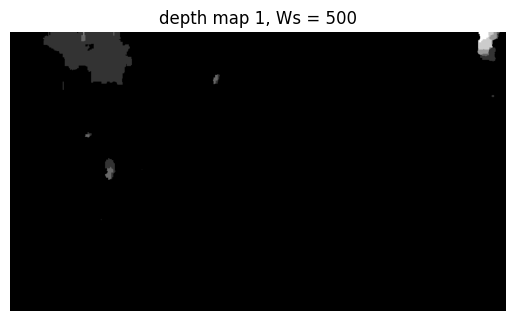

In [49]:
plt.imshow(optim_map_1, cmap='gray')
plt.title(f'depth map 1, Ws = {optiMaps.Ws}')
plt.axis('off')
plt.show

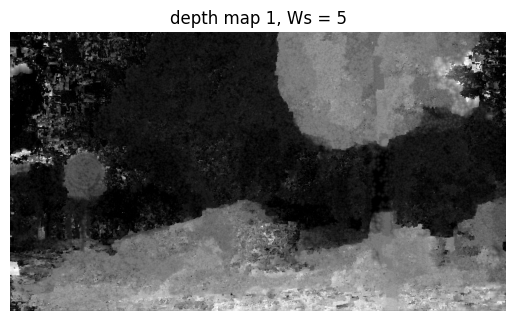

In [50]:
data_term = np.load('data_terms/part4_Doptim_frame_1.npy')
optiMaps.Ws = 5
fp, edges, edge_weights = optiMaps.compute_prior(1)
optim_map_1 = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp,algorithm='swap').reshape(H, W)
plt.imshow(optim_map_1, cmap='gray')
plt.title(f'depth map 1, Ws = {optiMaps.Ws}')
plt.axis('off')
plt.show()

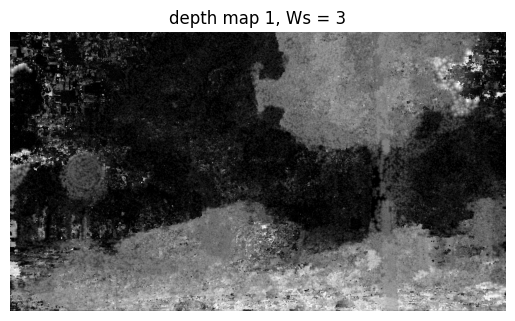

In [51]:
optiMaps.Ws = 3
fp, edges, edge_weights = optiMaps.compute_prior(1)
optim_map_1 = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp,algorithm='swap').reshape(H, W)
plt.imshow(optim_map_1, cmap='gray')
plt.title(f'depth map 1, Ws = {optiMaps.Ws}')
plt.axis('off')
plt.show()

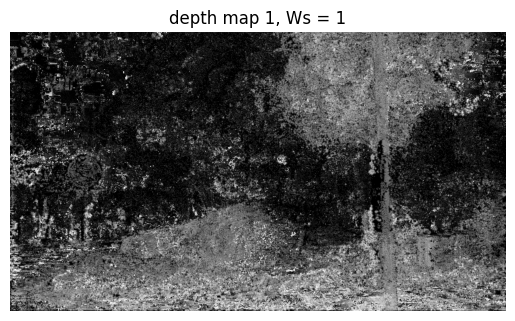

In [52]:
optiMaps.Ws = 1
fp, edges, edge_weights = optiMaps.compute_prior(1)
optim_map_1 = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp,algorithm='swap').reshape(H, W)
plt.imshow(optim_map_1, cmap='gray')
plt.title(f'depth map 1, Ws = {optiMaps.Ws}')
plt.axis('off')
plt.show()

## My best results(the number of frames I used is 5, the example depth map is from test.0001.jpg):
### For disparity initialization, the best result is when Ws = 500
![best result](part4_init_bestresult.png)
### For bundle optimization, the best result is when Ws = 3
![best_result2](part4_optim_bestresult.png)

## Discussion
1. All parameters play crucial roles in the generation of the depth map, not just Ws. When Ws increases, the depth map experiences reduced noise and details, resulting in a smoother appearance. However, other parameters also significantly influence the quality of the depth map, and the selection of disparity candidates is equally crucial.
2. The choice of the number of frames is paramount. A higher number of frames yield more information for the depth map generation, resulting in improved quality. Due to computational constraints, I opted for a selection of only 5 frames for the depth map generation.
3. The iteration count for bundle optimization is another critical factor. A greater number of iterations lead to the production of a superior depth map. However, due to computational limitations, I performed only a single iteration of bundle optimization.